<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/misc/Image_Search(Dual_Encoder).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

In [3]:
import time
import os
import collections
import json
import glob
from PIL import Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

In [5]:
! unzip -q annotations_trainval2014.zip
! rm annotations_trainval2014.zip
# ! ls annotations/

In [6]:
with open('annotations/captions_train2014.json', 'r') as f:
  annotations = json.load(f)['annotations']

In [ ]:
! wget http://images.cocodataset.org/zips/train2014.zip

In [8]:
! unzip -q train2014.zip
! rm train2014.zip

In [9]:
image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = "train2014" + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

In [10]:
image_paths = list(image_path_to_caption.keys())[:20000]
print(f"Number of images: {len(image_paths)}")

Number of images: 20000


a graffiti-ed stop sign across the street from a red car 
a vandalized stop sign and a red beetle on the road
a red stop sign with a bush bumper sticker under the word stop
a stop sign that has been vandalized is pictured in front of a parked car
a street sign modified to read stop bush


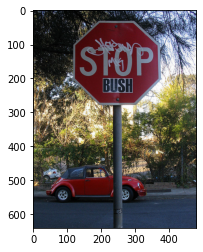

In [11]:
# Sample of the dataset

sample_image_path = image_paths[2]
img = mpimg.imread(sample_image_path)
imgplot = plt.imshow(img)

for caption in image_path_to_caption[sample_image_path]:
  print(caption)

In [12]:
captions_per_image = 4
caption_list = []
image_path_list = []
for image_path in image_paths:
    captions = image_path_to_caption[image_path][:captions_per_image]
    caption_list.extend(captions)
    image_path_list.extend([image_path] * len(captions))

In [13]:
limit = (90 * len(image_paths) // 100) * captions_per_image

sample_caption_list = caption_list[:20]
sample_image_path_list = image_path_list[:20]

train_caption_list = caption_list[:limit]
train_image_path_list = image_path_list[:limit]

valid_caption_list = caption_list[limit:]
valid_image_path_list = image_path_list[limit:]

print('Length of train samples: ', len(train_image_path_list))
print('Length of valid samples: ', len(valid_image_path_list))

Length of train samples:  72000
Length of valid samples:  8000


Caption:  a red stop sign with a bush bumper sticker under the word stop


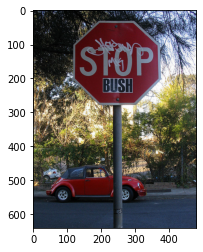

In [14]:
# Visualizing a train sample
sample_image_path = train_image_path_list[10]
img = mpimg.imread(sample_image_path)
imgplot = plt.imshow(img)

print('Caption: ', train_caption_list[10])

Caption:  sheep graze in a grassy field with two small black animals, possibly lambs or small sheepdogs, standing behind them


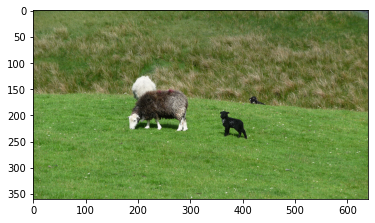

In [15]:
# Visualizing a valid sample
sample_image_path = valid_image_path_list[10]
img = mpimg.imread(sample_image_path)
imgplot = plt.imshow(img)

print('Caption: ', valid_caption_list[10])

In [16]:
# Sanity check
assert len(train_image_path_list) == len(train_caption_list)
assert len(valid_image_path_list) == len(valid_caption_list)

In [ ]:
# Loading external models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet34 = models.resnet34(pretrained=True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [18]:
class CustomDataset(Dataset):
  def __init__(self, image_list, caption_list=None, tokenizer=None, transforms=None):
    self.image_list = image_list
    self.caption_list = caption_list
    self.transforms = transforms
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    images = Image.open(self.image_list[idx]).convert('RGB')
    image_tensor = self.transforms(images)
    texts = self.caption_list[idx] if self.caption_list is not None else None
    tokens = self.tokenizer(texts, max_length=50, padding='max_length', truncation=True, return_tensors='pt') if texts is not None else None
    return {
        'img': image_tensor,
        'ids': tokens['input_ids'] if tokens is not None else [],
        'mask': tokens['attention_mask'] if tokens is not None else [],
    }

custom_transforms = transforms.Compose([transforms.Resize((64, 64)),
                                        transforms.ToTensor()])

In [19]:
sample_dataset = CustomDataset(sample_image_path_list, sample_caption_list, tokenizer, custom_transforms)

(64, 64, 3) torch.Size([1, 50]) torch.Size([1, 50])
a graffiti - ed stop sign across the street from a red car


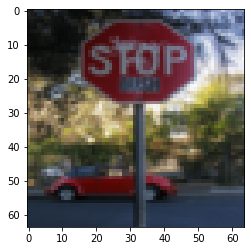

In [20]:
sample_loader = DataLoader(dataset=sample_dataset, batch_size=1, shuffle=True)
for sample in sample_loader:
  img = sample['img'].squeeze(0).permute(1, 2, 0).numpy()
  ids = sample['ids'].squeeze(1)
  mask = sample['mask'].squeeze(1)
  print(img.shape, ids.shape, mask.shape)
  break
outs = tokenizer.decode(ids[0], skip_special_tokens=True)
print(outs)
plt.imshow(img)

In [21]:
train_dataset = CustomDataset(train_image_path_list, train_caption_list, tokenizer, custom_transforms)
valid_dataset = CustomDataset(valid_image_path_list, valid_caption_list, tokenizer, custom_transforms)

In [22]:
class VisionEncoder(nn.Module):
  def __init__(self, model, embedding_size, num_layers, dropout_rate):
    super().__init__()
    self.model = model
    self.num_layers = num_layers
    self.gelu = nn.GELU()
    self.linear_1 = nn.Linear(1000, embedding_size)
    self.linear_2 = nn.Linear(embedding_size, embedding_size)
    self.dropout = nn.Dropout(dropout_rate)
    self.layer_norm = nn.LayerNorm(embedding_size)
  
  def forward(self, x):
    projected_emb = self.linear_1(self.model(x))
    for _ in range(self.num_layers):
      x = self.gelu(projected_emb)
      x = self.linear_2(x)
      x = self.dropout(x)
      x = x + projected_emb
      projected_emb = self.layer_norm(x)
    return projected_emb

In [23]:
class TextEncoder(nn.Module):
  def __init__(self, model, embedding_size, num_layers, dropout_rate):
    super().__init__()
    self.model = model
    self.num_layers = num_layers
    self.gelu = nn.GELU()
    self.linear_1 = nn.Linear(768, embedding_size)
    self.linear_2 = nn.Linear(embedding_size, embedding_size)
    self.dropout = nn.Dropout(dropout_rate)
    self.layer_norm = nn.LayerNorm(embedding_size)
  
  def forward(self, ids, mask):
    last_hidden_state = self.model(input_ids=ids, attention_mask=mask).last_hidden_state
    pooled_output = last_hidden_state[:, 0]
    projected_emb = self.linear_1(pooled_output)
    for _ in range(self.num_layers):
      x = self.gelu(projected_emb)
      x = self.linear_2(x)
      x = self.dropout(x)
      x = x + projected_emb
      projected_emb = self.layer_norm(x)
    return projected_emb

In [24]:
class DualEncoder(nn.Module):
  def __init__(self, vision_encoder, text_encoder, temperature=1.0):
    super().__init__()
    self.vision_encoder = vision_encoder
    self.text_encoder = text_encoder
    self.temperature = temperature
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, img, ids, mask):
    image_emb = self.vision_encoder(img)
    caption_emb = self.text_encoder(ids, mask)
    return image_emb, caption_emb
  
  def compute_loss(self, image_emb, caption_emb):
    logits = (caption_emb @ image_emb.T) / self.temperature

    image_similarity = image_emb @ image_emb.T
    caption_similarity = caption_emb @ caption_emb.T

    targets = self.softmax((caption_similarity + image_similarity) / (2 * self.temperature))
    _, targets = torch.max(targets, 1)

    caption_loss = F.cross_entropy(logits, targets)
    image_loss = F.cross_entropy(logits.T, targets.T)


    return (caption_loss + image_loss) / 2

In [25]:
vision_encoder = VisionEncoder(model_resnet34, 256, 1, 0.1)
text_encoder = TextEncoder(model_distilbert, 256, 1, 0.1)
dual_encoder = DualEncoder(vision_encoder, text_encoder, temperature=0.05)
dual_encoder.to(device)

params = sum(p.numel() for p in dual_encoder.parameters() if p.requires_grad)
print('Total Trainable Paramaters: ', params)

Total Trainable Paramaters:  88746280


In [26]:
BATCH_SIZE = 256
LEARNING_RATE = 3e-5
EPOCHS = 10

In [27]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print("Length of Train Loader: ", len(train_loader))
print("Length of Valid Loader: ", len(valid_loader))

Length of Train Loader:  282
Length of Valid Loader:  32


In [28]:
optimizer = torch.optim.AdamW(dual_encoder.parameters(), lr=LEARNING_RATE)

In [29]:
def compute_loss(model, data_loader, device):
  loss_list = []
  for sample in data_loader:
    img = sample['img'].to(device)
    ids = sample['ids'].squeeze(1).to(device)
    mask = sample['mask'].squeeze(1).to(device)
    img_emb, caption_emb = model(img, ids, mask)
    loss = model.compute_loss(img_emb, caption_emb)
    loss_list.append(loss.item())
  return torch.tensor(loss_list).mean()

start_time = time.time()
for epoch in range(EPOCHS):
  dual_encoder.train()
  for idx, sample in enumerate(train_loader):
    img = sample['img'].to(device)
    ids = sample['ids'].squeeze(1).to(device)
    mask = sample['mask'].squeeze(1).to(device)
    img_emb, caption_emb = dual_encoder(img, ids, mask)
    loss = dual_encoder.compute_loss(img_emb, caption_emb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # LOGGING
    if idx % 100 == 0:
      print('Batch: %04d/%04d || Epoch: %04d/%04d || Loss: %.2f' % (idx, len(train_loader), epoch+1, EPOCHS, loss.item()))
  
  dual_encoder.eval()
  with torch.set_grad_enabled(False):
    valid_loss = compute_loss(dual_encoder, valid_loader, device)
    print('Valid Loss: %.2f' % (valid_loss))
  epoch_elapsed_time = (time.time() - start_time) / 60
  print('Epoch elapsed time: %.2f min' % (epoch_elapsed_time))
total_train_time = (time.time() - start_time) / 60
print('Total training time: %.2f min' % (total_train_time))

Batch: 0000/0282 || Epoch: 0001/0010 || Loss: 649.43
Batch: 0100/0282 || Epoch: 0001/0010 || Loss: 181.53
Batch: 0200/0282 || Epoch: 0001/0010 || Loss: 130.97
Valid Loss: 83.33
Epoch elapsed time: 9.54 min
Batch: 0000/0282 || Epoch: 0002/0010 || Loss: 107.29
Batch: 0100/0282 || Epoch: 0002/0010 || Loss: 82.44
Batch: 0200/0282 || Epoch: 0002/0010 || Loss: 72.75
Valid Loss: 56.88
Epoch elapsed time: 18.98 min
Batch: 0000/0282 || Epoch: 0003/0010 || Loss: 66.84
Batch: 0100/0282 || Epoch: 0003/0010 || Loss: 53.20
Batch: 0200/0282 || Epoch: 0003/0010 || Loss: 42.75
Valid Loss: 25.40
Epoch elapsed time: 28.40 min
Batch: 0000/0282 || Epoch: 0004/0010 || Loss: 42.80
Batch: 0100/0282 || Epoch: 0004/0010 || Loss: 36.45
Batch: 0200/0282 || Epoch: 0004/0010 || Loss: 24.53
Valid Loss: 14.28
Epoch elapsed time: 37.81 min
Batch: 0000/0282 || Epoch: 0005/0010 || Loss: 20.71
Batch: 0100/0282 || Epoch: 0005/0010 || Loss: 15.39
Batch: 0200/0282 || Epoch: 0005/0010 || Loss: 11.56
Valid Loss: 11.22
Epoch e

In [31]:
test_dataset = CustomDataset(image_list=image_paths[:20000], transforms=custom_transforms)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

torch.Size([256, 3, 64, 64])


In [52]:
print('Length of Test Loader: ', len(test_loader))

Length of Test Loader:  79


In [59]:
text = "People at the beach with surf board"
tokens = tokenizer(text, max_length=50, padding='max_length', truncation=True, return_tensors='pt')
ids = tokens['input_ids']
mask = tokens['attention_mask']
list_img = []
list_prob = []
dual_encoder.eval()
with torch.set_grad_enabled(False):
  for idx, sample in enumerate(test_loader):
    if idx % 10 == 0:
      print('Batch: %04d/%04d' % (idx, len(test_loader)))
    img = sample['img'].to(device)
    ids = ids.to(device)
    mask = mask.to(device)
    img_emb, text_emb = dual_encoder(img, ids, mask)
    normalized_img_emb = F.normalize(img_emb, p=2, dim=1)
    normalized_text_emb = F.normalize(text_emb, p=2, dim=1)
    dot_sim = normalized_text_emb @ normalized_img_emb.T
    prob, results = torch.topk(dot_sim, k=1)
    list_prob.append(prob.item())
    list_img.append(img[results.item()].permute(1, 2, 0).cpu().numpy())

Batch: 0000/0079
Batch: 0010/0079
Batch: 0020/0079
Batch: 0030/0079
Batch: 0040/0079
Batch: 0050/0079
Batch: 0060/0079
Batch: 0070/0079


In [ ]:
_, indices = torch.topk(torch.tensor(list_prob), k=3)
indices = indices.numpy()

Your input:  People at the beach with surf board


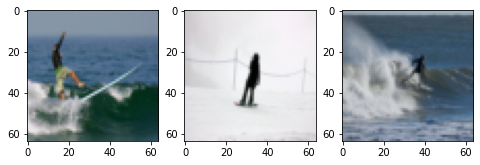

In [74]:
print('Your input: ', text)
_, axs = plt.subplots(1, 3, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(list_img, axs):
    ax.imshow(img)
plt.show()